<a href="https://colab.research.google.com/github/alexandrasouly/fastai_exploration/blob/main/pet_breeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 727kB 31.9MB/s 
     |████████████████████████████████| 194kB 50.0MB/s 
     |████████████████████████████████| 1.2MB 22.8MB/s 
     |████████████████████████████████| 51kB 9.6MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 61kB 11.2MB/s 
Mounted at /content/gdrive


In [ ]:

from fastai.vision.all import *
path = untar_data(URLs.PETS, dest = '.')

By examining these filenames, we can see how they appear to be structured. Each filename contains the pet breed, and then an underscore (_), a number, and finally the file extension. We need to create a piece of code that extracts the breed from a single Path.

In [ ]:
fname = (path/"images").ls()[0]
re.findall(r'(.+)_\d+.jpg$', fname.name)

['staffordshire_bull_terrier']

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders("./oxford-iiit-pet/images")

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


We need our images to have the same dimensions, so that they can collate into tensors to be passed to the GPU. We also want to minimize the number of distinct augmentation computations we perform. The performance requirement suggests that we should, where possible, compose our augmentation transforms into fewer transforms (to reduce the number of computations and the number of lossy operations) and transform the images into uniform sizes (for more efficient processing on the GPU).

The challenge is that, if performed after resizing down to the augmented size, various common data augmentation transforms might introduce spurious empty zones, degrade data, or both. For instance, rotating an image by 45 degrees fills corner regions of the new bounds with emptiness, which will not teach the model anything. Many rotation and zooming operations will require interpolating to create pixels. These interpolated pixels are derived from the original image data but are still of lower quality.

Resize images to relatively "large" dimensions—that is, dimensions significantly larger than the target training dimensions.
Compose all of the common augmentation operations (including a resize to the final target size) into one, and perform the combined operation on the GPU only once at the end of processing, rather than performing the operations individually and interpolating multiple times.
The first step, the resize, creates images large enough that they have spare margin to allow further augmentation transforms on their inner regions without creating empty zones. This transformation works by resizing to a square, using a large crop size. On the training set, the crop area is chosen randomly, and the size of the crop is selected to cover the entire width or height of the image, whichever is smaller.

In the second step, the GPU is used for all data augmentation, and all of the potentially destructive operations are done together, with a single interpolation at the end.

To implement this process in fastai you use Resize as an item transform with a large size, and RandomResizedCrop as a batch transform with a smaller size. RandomResizedCrop will be added for you if you include the min_scale parameter in your aug_transforms function, as was done in the DataBlock call in the previous section. Alternatively, you can use pad or squish instead of crop (the default) for the initial Resize.

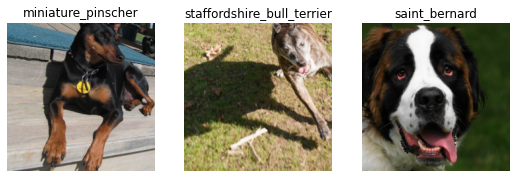

In [ ]:

dls.show_batch(nrows=1, ncols=3)

In [ ]:
 pets.summary("./oxford-iiit-pet/images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      oxford-iiit-pet/images/Russian_Blue_174.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      oxford-iiit-pet/images/Russian_Blue_174.jpg
    applying partial gives
      Russian_Blue
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(9)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(9))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Resize -- {'size': (

You can see exactly how we gathered the data and split it, how we went from a filename to a sample (the tuple (image, category)), then what item transforms were applied

Once you think your data looks right, we generally recommend the next step should be using it to train a simple model. We often see people put off the training of an actual model for far too long. As a result, they don't actually find out what their baseline results look like. Perhaps your problem doesn't need lots of fancy domain-specific engineering. Or perhaps the data doesn't seem to train the model at all. These are things that you want to know as soon as possible.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.533045,0.372549,0.129229,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.514467,0.326302,0.106225,01:11
1,0.328387,0.237960,0.074425,01:12



Let's take a look at the activations of our model. To actually get a batch of real data from our DataLoaders, we can use the one_batch method:

In [ ]:
x,y = dls.one_batch()
y

TensorCategory([21, 28, 19,  1, 23, 20, 21, 14,  2, 14,  8,  7, 25,  8, 29, 12, 18, 18, 33, 21, 35, 16, 25, 16, 36, 32,  9, 20, 18,  0,  8,  9, 13, 11, 20,  7,  8, 32, 36, 13, 19, 16, 23, 31,  6,  0, 22, 21,
        34, 11, 11, 16,  3, 25,  3,  1, 16,  5, 33, 34, 30, 36, 18,  9], device='cuda:0')

Our batch size is 64, so we have 64 rows in this tensor. Each row is a single integer between 0 and 36, representing our 37 possible pet breeds. We can view the predictions (that is, the activations of the final layer of our neural network) using Learner.get_preds. This function either takes a dataset index (0 for train and 1 for valid) or an iterator of batches. Thus, we can pass it a simple list with our batch to get our predictions. It returns predictions and targets by default, but since we already have the targets, we can effectively ignore them by assigning to the special variable _.
The actual predictions are 37 probabilities between 0 and 1, which add up to 1 in total. To transform the activations of our model into predictions like this, we used something called the softmax activation function.

In [ ]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([2.3211e-08, 1.4489e-08, 4.1632e-07, 7.8137e-09, 1.0130e-07, 2.5921e-07, 6.9454e-07, 2.9466e-06, 3.6557e-07, 2.4614e-08, 1.9919e-08, 1.3653e-08, 3.7966e-07, 2.0220e-08, 5.7255e-08, 1.1571e-08,
        3.5541e-09, 2.7942e-08, 2.7231e-08, 4.7713e-06, 1.0237e-07, 9.9944e-01, 5.3930e-07, 4.1274e-07, 4.8928e-06, 1.6368e-06, 6.1529e-08, 4.3671e-06, 2.1664e-07, 1.5915e-07, 3.7235e-06, 5.2892e-04,
        5.9512e-08, 2.5724e-07, 3.4142e-08, 6.2820e-07, 5.8776e-09])

We haven't specified loss anywhere. fastai will generally try to select an appropriate loss function based on what kind of data and model you are using. In this case we have image data and a categorical outcome, so fastai will default to using cross-entropy loss.

loss(x,class)= − log(exp(x[class]) / ∑ exp(x[j]))
 

loss_func = nn.CrossEntropyLoss()

## Model Interpretation

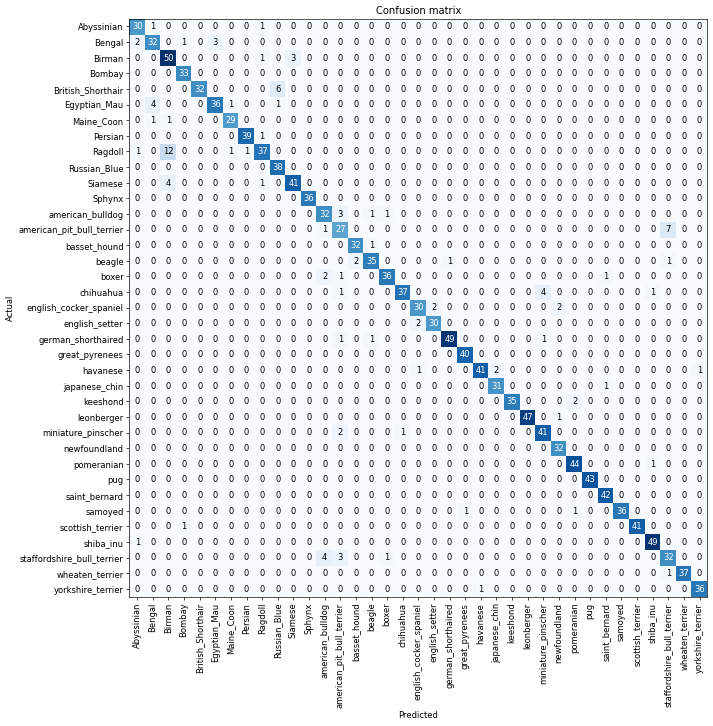

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


We have 37 different breeds of pet, which means we have 37×37 entries in this giant matrix! Instead, we can use the most_confused method, which just shows us the cells of the confusion matrix with the most incorrect predictions (here, with at least 5 or more):

In [ ]:
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', 12),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('British_Shorthair', 'Russian_Blue', 6)]


## Improving Our Model

What do we do to find the perfect learning rate—not too high, and not too low? In 2015 the researcher Leslie Smith came up with a brilliant idea, called the learning rate finder. His idea was to start with a very, very small learning rate, something so small that we would never expect it to be too big to handle. We use that for one mini-batch, find what the losses are afterwards, and then increase the learning rate by some percentage (e.g., doubling it each time). Then we do another mini-batch, track the loss, and double the learning rate again. We keep doing this until the loss gets worse, instead of better. This is the point where we know we have gone too far. We then select a learning rate a bit lower than this point. Our advice is to pick either:

One order of magnitude less than where the minimum loss was achieved (i.e., the minimum divided by 10)
The last point where the loss was clearly decreasing
The learning rate finder computes those points on the curve to help you. Both these rules usually give around the same value. In the first chapter, we didn't specify a learning rate, using the default value from the fastai library (which is 1e-3):



We can see on this plot that in the range 1e-6 to 1e-3, nothing really happens and the model doesn't train. Then the loss starts to decrease until it reaches a minimum, and then increases again. We don't want a learning rate greater than 1e-1 as it will give a training that diverges like the one before (you can try for yourself), but 1e-1 is already too high: at this stage we've left the period where the loss was decreasing steadily.

In this learning rate plot it appears that a learning rate around 3e-3 would be appropriate, so let's choose that:

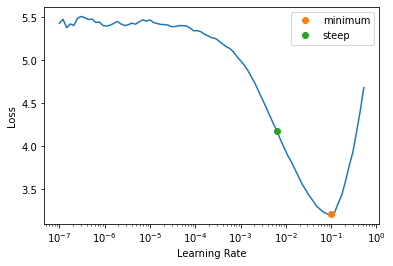

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 6.31e-03


We now know that a convolutional neural network consists of many linear layers with a nonlinear activation function between each pair, followed by one or more final linear layers with an activation function such as softmax at the very end. The final linear layer uses a matrix with enough columns such that the output size is the same as the number of classes in our model (assuming that we are doing classification).

This final linear layer is unlikely to be of any use for us when we are fine-tuning in a transfer learning setting, because it is specifically designed to classify the categories in the original pretraining dataset. So when we do transfer learning we remove it, throw it away, and replace it with a new linear layer with the correct number of outputs for our desired task (in this case, there would be 37 activations).

This newly added linear layer will have entirely random weights. Therefore, our model prior to fine-tuning has entirely random outputs. But that does not mean that it is an entirely random model! All of the layers prior to the last one have been carefully trained to be good at image classification tasks in general. 

We want to train a model in such a way that we allow it to remember all of these generally useful ideas from the pretrained model, use them to solve our particular task (classify pet breeds), and only adjust them as required for the specifics of our particular task.

Our challenge when fine-tuning is to replace the random weights in our added linear layers with weights that correctly achieve our desired task (classifying pet breeds) without breaking the carefully pretrained weights and the other layers. There is actually a very simple trick to allow this to happen: tell the optimizer to only update the weights in those randomly added final layers. Don't change the weights in the rest of the neural network at all. This is called freezing those pretrained layers.

When we create a model from a pretrained network fastai automatically freezes all of the pretrained layers for us. When we call the fine_tune method fastai does two things:

Trains the randomly added layers for one epoch, with all other layers frozen
Unfreezes all of the layers, and trains them all for the number of epochs requested
Although this is a reasonable default approach, it is likely that for your particular dataset you may get better results by doing things slightly differently. The fine_tune method has a number of parameters you can use to change its behavior, but it might be easiest for you to just call the underlying methods directly if you want to get some custom behavior.


So let's try doing this manually ourselves. First of all we will train the randomly added layers for three epochs, using fit_one_cycle.

In [ ]:

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.127855,0.357482,0.108931,01:10
1,0.516044,0.280048,0.090663,01:11
2,0.329326,0.218716,0.077131,01:11


In [ ]:
learn.unfreeze()

and run lr_find again, because having more layers to train, and weights that have already been trained for three epochs, means our previously found learning rate isn't appropriate any more:

SuggestedLRs(valley=tensor(7.5858e-07))

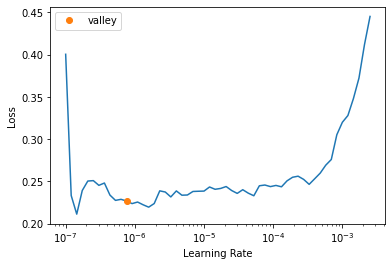

In [ ]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

Note that the graph is a little different from when we had random weights: we don't have that sharp descent that indicates the model is training. That's because our model has been trained already. Here we have a somewhat flat area before a sharp increase, and we should take a point well before that sharp increase—for instance, 1e-6. The point with the maximum gradient isn't what we look for here and should be ignored.

In [ ]:

learn.fit_one_cycle(6, lr_max=1e-6)

epoch,train_loss,valid_loss,error_rate,time
0,0.262249,0.219312,0.077808,01:15
1,0.262886,0.217796,0.077131,01:15
2,0.251214,0.217323,0.074425,01:16
3,0.251034,0.218856,0.077131,01:16
4,0.250269,0.215516,0.076455,01:16
5,0.250123,0.218276,0.074425,01:16



This has improved our model a bit, but there's more we can do. The deepest layers of our pretrained model might not need as high a learning rate as the last ones, so we should probably use different learning rates for those—this is known as using discriminative learning rates.

## Discriminative Learning Rates
Even after we unfreeze, we still care a lot about the quality of those pretrained weights. We would not expect that the best learning rate for those pretrained parameters would be as high as for the randomly added parameters, even after we have tuned those randomly added parameters for a few epochs. Remember, the pretrained weights have been trained for hundreds of epochs, on millions of images.


fastai lets you pass a Python slice object anywhere that a learning rate is expected. The first value passed will be the learning rate in the earliest layer of the neural network, and the second value will be the learning rate in the final layer. The layers in between will have learning rates that are multiplicatively equidistant throughout that range. Let's use this approach to replicate the previous training, but this time we'll only set the lowest layer of our net to a learning rate of 1e-7; the other layers will scale up to 1e-4. Let's train for a while and see what happens:

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-7,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.155279,0.341486,0.108254,01:11
1,0.535389,0.329589,0.104871,01:11
2,0.337305,0.247529,0.080514,01:11


epoch,train_loss,valid_loss,error_rate,time
0,0.254750,0.251586,0.082544,01:16
1,0.252992,0.242341,0.081867,01:15
2,0.254453,0.236556,0.074425,01:16
3,0.233900,0.233358,0.079838,01:16
4,0.225595,0.228085,0.075778,01:15
5,0.206154,0.223493,0.071719,01:15
6,0.192995,0.228425,0.074425,01:16
7,0.194992,0.217756,0.070365,01:15
8,0.182174,0.221520,0.073748,01:16
9,0.175293,0.220448,0.072395,01:16


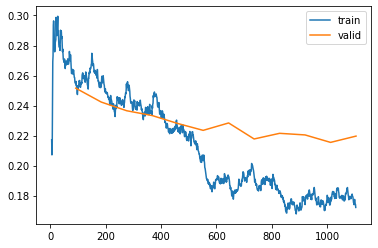

In [ ]:
learn.recorder.plot_loss()

As you can see, the training loss keeps getting better and better. But notice that eventually the validation loss improvement slows, and sometimes even gets worse! This is the point at which the model is starting to over fit. In particular, the model is becoming overconfident of its predictions. But this does not mean that it is getting less accurate, necessarily. Take a look at the table of training results per epoch, and you will often see that the accuracy continues improving, even as the validation loss gets worse. In the end what matters is your accuracy, or more generally your chosen metrics, not the loss. The loss is just the function we've given the computer to help us to optimize.

Another decision you have to make when training the model is for how long to train for. We'll consider that next.

Selecting the Number of Epochs
Often you will find that you are limited by time, rather than generalization and accuracy, when choosing how many epochs to train for. So your first approach to training should be to simply pick a number of epochs that will train in the amount of time that you are happy to wait for. Then look at the training and validation loss plots, as shown above, and in particular your metrics, and if you see that they are still getting better even in your final epochs, then you know that you have not trained for too long.

On the other hand, you may well see that the metrics you have chosen are really getting worse at the end of training. Remember, it's not just that we're looking for the validation loss to get worse, but the actual metrics. Your validation loss will first get worse during training because the model gets overconfident, and only later will get worse because it is incorrectly memorizing the data. We only care in practice about the latter issue. Remember, our loss function is just something that we use to allow our optimizer to have something it can differentiate and optimize; it's not actually the thing we care about in practice.

Before the days of 1cycle training it was very common to save the model at the end of each epoch, and then select whichever model had the best accuracy out of all of the models saved in each epoch. This is known as early stopping. However, this is very unlikely to give you the best answer, because those epochs in the middle occur before the learning rate has had a chance to reach the small values, where it can really find the best result. Therefore, if you find that you have overfit, what you should actually do is retrain your model from scratch, and this time select a total number of epochs based on where your previous best results were found.

If you have the time to train for more epochs, you may want to instead use that time to train more parameters—that is, use a deeper architecture.

Deeper Architectures
In general, a model with more parameters can model your data more accurately. (There are lots and lots of caveats to this generalization, and it depends on the specifics of the architectures you are using, but it is a reasonable rule of thumb for now.) For most of the architectures that we will be seeing in this book, you can create larger versions of them by simply adding more layers. However, since we want to use pretrained models, we need to make sure that we choose a number of layers that have already been pretrained for us.

This is why, in practice, architectures tend to come in a small number of variants. For instance, the ResNet architecture that we are using in this chapter comes in variants with 18, 34, 50, 101, and 152 layer, pretrained on ImageNet. A larger (more layers and parameters; sometimes described as the "capacity" of a model) version of a ResNet will always be able to give us a better training loss, but it can suffer more from overfitting, because it has more parameters to overfit with.

In general, a bigger model has the ability to better capture the real underlying relationships in your data, and also to capture and memorize the specific details of your individual images.

However, using a deeper model is going to require more GPU RAM, so you may need to lower the size of your batches to avoid an out-of-memory error. This happens when you try to fit too much inside your GPU and looks like:

Cuda runtime error: out of memory
You may have to restart your notebook when this happens. The way to solve it is to use a smaller batch size, which means passing smaller groups of images at any given time through your model. You can pass the batch size you want to the call creating your DataLoaders with bs=.

The other downside of deeper architectures is that they take quite a bit longer to train. One technique that can speed things up a lot is mixed-precision training. This refers to using less-precise numbers (half-precision floating point, also called fp16) where possible during training. As we are writing these words in early 2020, nearly all current NVIDIA GPUs support a special feature called tensor cores that can dramatically speed up neural network training, by 2-3x. They also require a lot less GPU memory. To enable this feature in fastai, just add to_fp16() after your Learner creation (you also need to import the module).

You can't really know ahead of time what the best architecture for your particular problem is—you need to try training some. So let's try a ResNet-50 now with mixed precision.

In [ ]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.305293,0.309762,0.100812,01:06
1,0.569768,0.326596,0.106225,01:06
2,0.414834,0.296157,0.088633,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.256330,0.236426,0.070365,01:08
1,0.287868,0.445005,0.121786,01:08
2,0.266857,0.298504,0.089986,01:08
3,0.167255,0.227497,0.071719,01:08
4,0.083999,0.208141,0.058187,01:08
5,0.059035,0.200373,0.052774,01:07



You'll see here we've gone back to using fine_tune, since it's so handy! We can pass freeze_epochs to tell fastai how many epochs to train for while frozen. It will automatically change learning rates appropriately for most datasets.